In [48]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from pathlib import Path
import json
import matplotlib.pyplot as plt
import seaborn as sns
PATH = Path('data')
list(PATH.iterdir())

[PosixPath('data/houston_processed.feather'),
 PosixPath('data/location_history.json'),
 PosixPath('data/houston.csv')]

In [2]:
df = pd.read_feather(PATH/'houston_processed.feather')

In [8]:
df.shape
df.head()

(353793, 15)

,accuracy,altitude,heading,latitudeE7,longitudeE7,timestampMs,velocity,verticalAccuracy,act_conf1,act_type1,act_cont2,act_type2,extra_intVal,extra_name,extra_type
0,8,30.0,161.0,296676529,-952764549,1386536307870,0.0,NaN,100.0,STILL,NaN,None,NaN,None,None
1,3,30.0,307.0,296677688,-952765729,1386536352800,0.0,NaN,NaN,None,NaN,None,NaN,None,None
2,6,31.0,320.0,296677783,-952765824,1386536372859,0.0,NaN,NaN,None,NaN,None,NaN,None,None
3,5,31.0,320.0,296677802,-952765843,1386536388113,0.0,NaN,100.0,TILTING,NaN,None,NaN,None,None
4,12,NaN,NaN,296678120,-952766469,1386536423014,NaN,NaN,NaN,None,NaN,None,NaN,None,None


In [5]:
df.dtypes

accuracy              int64
altitude            float64
heading             float64
latitudeE7            int64
longitudeE7           int64
timestampMs           int64
velocity            float64
verticalAccuracy    float64
act_conf1           float64
act_type1            object
act_cont2           float64
act_type2            object
extra_intVal        float64
extra_name           object
extra_type           object
dtype: object

# TODO: clean invalid longitude and latitude

# TODO: single feature EDA

In [9]:
(df.isnull().sum() / len(df)) * 100

accuracy              0.000000
altitude             51.663826
heading              83.053367
latitudeE7            0.000000
longitudeE7           0.000000
timestampMs           0.000000
velocity             98.378713
verticalAccuracy    100.000000
act_conf1            47.112860
act_type1            47.112860
act_cont2            74.106045
act_type2            74.106045
extra_intVal         99.985585
extra_name           99.985585
extra_type           99.985585
dtype: float64

## take a look at feature with high % NaN

In [11]:
df.heading.describe()
# look like degree

count    59956.000000
mean       186.884615
std        101.600448
min          0.000000
25%        107.000000
50%        180.000000
75%        278.000000
max        359.000000
Name: heading, dtype: float64

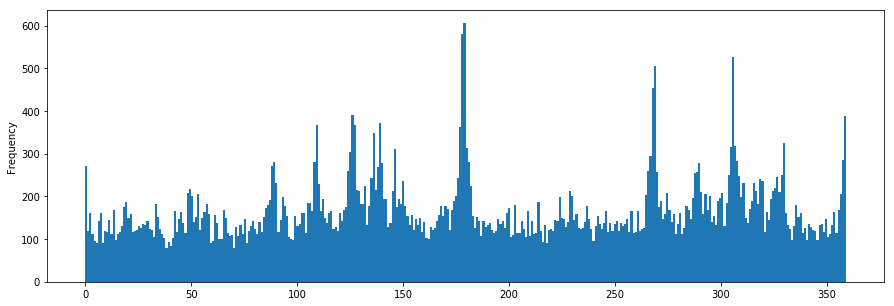

In [39]:
df.heading.plot(kind='hist',bins=360,figsize=(15,5))

In [19]:
df.velocity.describe()

count    5736.000000
mean        2.391039
std         5.903613
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        34.000000
Name: velocity, dtype: float64

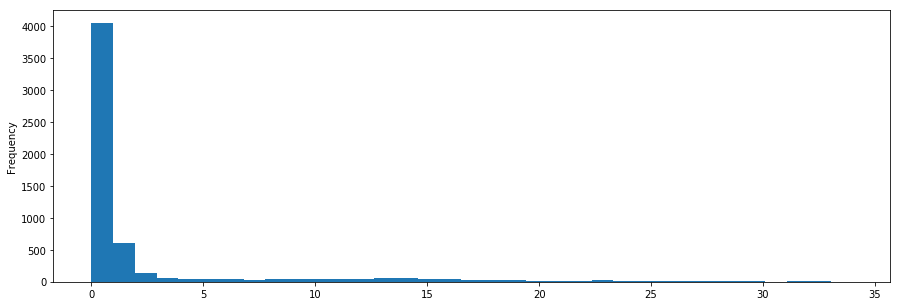

In [44]:
df.velocity.plot(kind='hist',bins=35,figsize=(15,5))

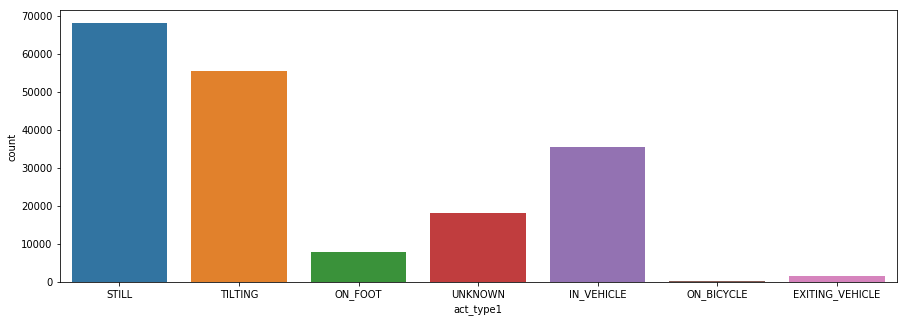

In [51]:
fig, ax = plt.subplots(figsize=(15,5))
sns.countplot(ax=ax,x=df.act_type1,data=df)

# TODO: clustering and plotting cluster

# TODO: identify weekday and weekend point

# TODO: identify 'home' and 'work' cluster

# TODO: identify 'vacation' and other clusters